In [446]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [447]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

import fastai
from fastai import *
from fastai.vision import *
from ipyexperiments import *

In [448]:
data_path = Path('../data/whale/')

In [449]:
data_path.ls()

[PosixPath('../data/whale/train'),
 PosixPath('../data/whale/train.csv'),
 PosixPath('../data/whale/cropped_training'),
 PosixPath('../data/whale/test_csv_2.csv'),
 PosixPath('../data/whale/train_csv_2.csv'),
 PosixPath('../data/whale/submissions'),
 PosixPath('../data/whale/models'),
 PosixPath('../data/whale/cropped_test'),
 PosixPath('../data/whale/test')]

### Cropped Data

In [88]:
train_df = pd.read_csv(data_path/'train.csv')

In [89]:
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [90]:
# some class
train_known_df = train_df[train_df.Id != 'new_whale']

In [185]:
id_ = np.random.choice(train_known_df.Id)
dummy_df = train_known_df[train_known_df.Id == id_].reset_index(drop=True)
dummy_df.shape, id_

((17, 2), 'w_007fefa')

In [186]:
data = ImageDataBunch.from_df(path=data_path, df=dummy_df, folder="cropped_training", bs=4,
                              valid_pct=0, size=(112,224),
                              resize_method=ResizeMethod.SQUISH)

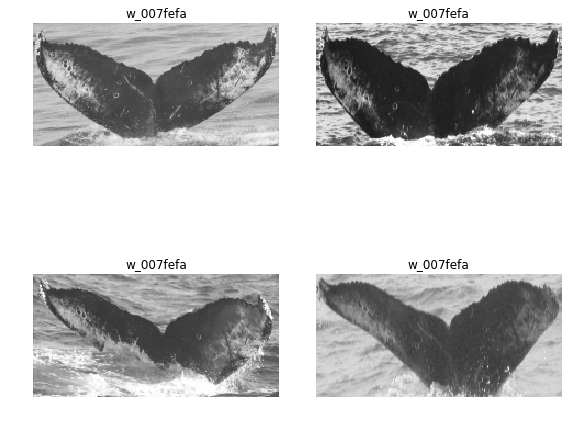

In [187]:
data.show_batch(rows=2, ds_type=DatasetType.Train)

In [416]:
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj,self.data = (self.img1,self.img2),[self.img1.data,self.img2.data]
        self.stats = torch.tensor(imagenet_stats)
        
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, **kwargs)
        self.data = [self.img1.data,self.img2.data]
        self.data = [normalize(t, *self.stats) for t in self.data]
        return self
    
    def to_one(self): 
        """rather than in reconstruct() denormalizations for show methods happen here"""
        return Image(torch.cat([denormalize(t, *self.stats) for t in self.data],2))
    
    def __repr__(self):
        return f'{self.__class__.__name__}{(self.img1.shape, self.img2.shape)}'
        
        
class ImageTupleList(ImageItemList):
#     _label_cls=TargetTupleList
    def __init__(self, items, **kwargs):
        """items should be tuple of image paths"""
        super().__init__(items, **kwargs)
    
    def get(self, i):
        fn1, fn2 = self.items[i]
        img1, img2 = open_image(fn1), open_image(fn2)
        return ImageTuple(img1, img2)
    
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]),Image(t[1]))
    
    @classmethod
    def from_folders(cls, path, folderA, folderB, **kwargs):
        itemsB = ImageItemList.from_folder(path/folderB).items
        res = super().from_folder(path/folderA, itemsB=itemsB, **kwargs)
        res.path = path
        return res
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)
            
def get_pair_data(df,
             bs=64,
             size=(112,224),
             train_folder='cropped_training',
             test_folder='cropped_test',
             stats=imagenet_stats):
    """
    Creates pair image databunch from dataframe with cols [ImageA, ImageB, Is_Matched]
    Useful for siamese network as it takes two images as input
    """
    # list of fnames
    itemsA = ImageItemList.from_df(df, cols=['ImageA'],
                                   path=data_path, folder='cropped_training').items
    itemsB = ImageItemList.from_df(df, cols=['ImageB'],
                                   path=data_path, folder='cropped_training').items
    target = df['Is_Matched'].values
    n = len(target)
    
    # random split
    np.random.seed(42)
    shuffled_idxs = np.random.permutation(range(n))
    n_val = max(1, int((n*0.1)))
    val_idxs, trn_idxs = shuffled_idxs[:n_val], shuffled_idxs[n_val:]
    
    itemlist = ImageTupleList(list(zip(itemsA, itemsB)))
    itemlists = itemlist.split_by_idxs(trn_idxs, val_idxs) # split doesn't split itemsB !!!
    labellists = itemlists.label_from_lists(target[trn_idxs], target[val_idxs])
    labellists = labellists.add_test(ImageItemList.from_folder(data_path/'cropped_test'))
    data = (labellists.transform(get_transforms(p_affine=0, p_lighting=0, max_warp=0, max_zoom=0),
                             size=size,
                             resize_method=ResizeMethod.SQUISH, 
                             padding_mode='zeros')
                  .databunch(bs=bs))
    
    return data

In [417]:
final_df = pd.read_csv("final_df_sml.csv")

In [418]:
df = final_df
itemsA = ImageItemList.from_df(df, cols=['ImageA'],
                               path=data_path, folder='cropped_training').items
itemsB = ImageItemList.from_df(df, cols=['ImageB'],
                               path=data_path, folder='cropped_training').items
target = df['Is_Matched'].values

In [419]:
itemlist = ImageTupleList(items=list(zip(itemsA, itemsB)))

In [420]:
itemlist

ImageTupleList (28044 items)
[ImageTuple(torch.Size([3, 421, 1035]), torch.Size([3, 346, 623])), ImageTuple(torch.Size([3, 149, 197]), torch.Size([3, 587, 739])), ImageTuple(torch.Size([3, 389, 1050]), torch.Size([3, 411, 1050])), ImageTuple(torch.Size([3, 438, 969]), torch.Size([3, 283, 952])), ImageTuple(torch.Size([3, 384, 1020]), torch.Size([3, 310, 1050]))]...
Path: .

In [426]:
def show_same():
    for i in range(len(data.train_ds)):
        if data.train_ds[i][1].data == 1:
            print(data.train_ds.items[i][0], data.train_ds.items[i][1])
            yield data.train_ds[i][0].to_one()

In [423]:
data = get_pair_data(final_df)

In [427]:
gen = show_same()

../data/whale/cropped_training/78f190f6c.jpg ../data/whale/cropped_training/a978323bf.jpg


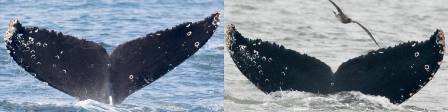

In [445]:
next(gen)

In [432]:
final_df[final_df.ImageA.isin(['d5b30fcb4.jpg'])]

,ImageA,ImageB,Is_Matched
4862,d5b30fcb4.jpg,21c4cea6b.jpg,1
9100,d5b30fcb4.jpg,01e878aad.jpg,1
11882,d5b30fcb4.jpg,b85af3d08.jpg,1


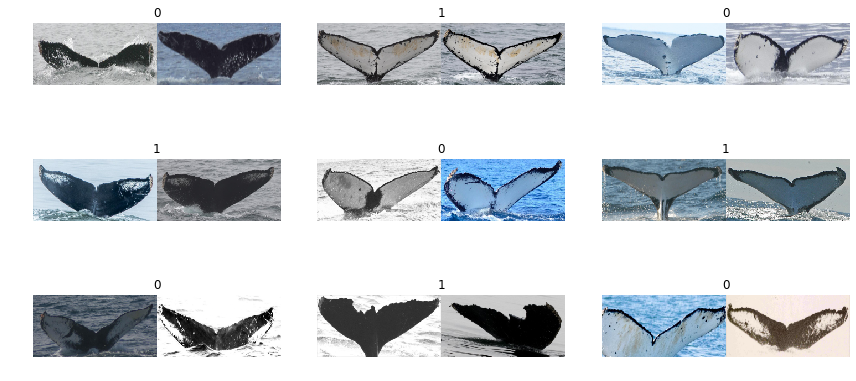

In [452]:
data.show_batch(rows=3)